In [ ]:
import random
import torch


class DynamicNet(torch.nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(DynamicNet, self).__init__()
    self.fc1 = torch.nn.Linear(input_size, hidden_size)
    self.activ1 = torch.nn.ReLU()
    self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
    self.activ2 = torch.nn.ReLU()
    self.fc3 = torch.nn.Linear(hidden_size, output_size)

  def forward(self, x):
    x = self.fc1(x)
    x = self.activ1(x)
    x = self.fc2(x)
    x = self.activ2(x)
    x = self.fc3(x)
    return x


# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 100, 4, 20, 1

# Create random Tensors to hold inputs and outputs
x = torch.rand(N, D_in)*2 - 1
y = torch.rand(N, D_out)*2 - 1

# Construct our model by instantiating the class defined above
model = DynamicNet(D_in, H, D_out)
model.train()
# Construct our loss function and an Optimizer. Training this strange model with
# vanilla stochastic gradient descent is tough, so we use momentum
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
for t in range(50000):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    # Compute and print loss
    loss = criterion(y_pred, y)
    if t % 1000 == 99:
        print(t, loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

99 24.96439552307129
1099 16.380176544189453
2099 7.693582057952881
3099 3.3774001598358154
4099 1.1165878772735596
5099 0.478726327419281
6099 0.29525336623191833
7099 0.13105274736881256
8099 0.2545658349990845
9099 0.0561399906873703
10099 0.3505863547325134
11099 0.04743776470422745
12099 0.020679103210568428
13099 0.05721518397331238
14099 0.031359754502773285
15099 0.1467076539993286
16099 0.04939378798007965
17099 0.003926508128643036
18099 0.018337039276957512
19099 0.05546842887997627
20099 0.005841516889631748
21099 0.0019131478620693088
22099 0.03393135964870453
23099 0.0015718098729848862
24099 0.0028873449191451073
25099 0.002199036069214344
26099 0.0003247046552132815
27099 0.0021567787043750286
28099 0.001965985633432865
29099 0.00022823958715889603
30099 0.0002949252666439861
31099 7.709933561272919e-05
32099 5.820680962642655e-05
33099 3.996855957666412e-05
34099 0.00015583487402182072
35099 6.494151602964848e-05
36099 3.283657133579254e-05
37099 1.5049105059006251e-05

In [ ]:
model.eval()
x_test = torch.randn(100, 4)
y_test = model(x_test)
print(list([1 if i > 0 else 0 for i in y_test.squeeze()]))

[0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0]


In [ ]:
import numpy as np
size = 5000
samples = []
key_size = 32
tail = key_size % 3
frequency = []
k = 101
for i in range(k):
  frequency.append(0)
etalonFreq = 1 / k
etalonNum = size / k
for i in range(size):
  samples.append(0)
  x_test = torch.randn(100, 4)
  y_test = list([i.item() for i in model(x_test).squeeze()])
  y_test = list([(int)(i * 10000000) % 10  for i in y_test if (int)(i * 10000000) % 10 < 8])
# print(y_test, len(y_test))
  for j in range(0, key_size//3):
    samples[i] = (samples[i] << 3) | y_test[j]
  samples[i] = (samples[i] << tail) | (y_test[key_size] & (2**tail - 1))
  samples[i] = samples[i] / (2**key_size)
  frequency[(int)(samples[i] // etalonFreq)] += 1;
  # print(samples[i], (int)(samples[i] // etalonFreq))


In [ ]:


hi = 0
for i in range(k):
  hi += (frequency[i] - etalonNum)**2;
hi *= 1 / etalonNum;
print(hi)

92.09679999999997


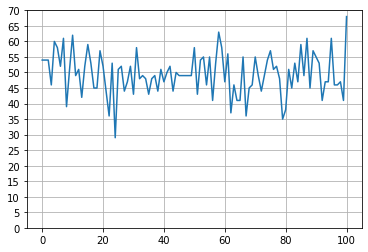

In [ ]:
import matplotlib.pyplot as plt
plt.plot(frequency)
plt.yticks(np.arange(0,75,5))
plt.grid()
plt.show()

In [ ]:
print(np.mean(frequency))

49.504950495049506


In [ ]:
print(np.mean(samples))

0.4981913342386484


In [ ]:
print(np.std(samples)**2)

0.08523751382883181
